<p>&nbsp;</p>

## **Lab 2**

<p>&nbsp;</p>

<font size = "5">

Syracuse University  
IST 718 Big Data Analytics  
Spring 2022

<p>&nbsp;</p>

## **Introduction**

<p>&nbsp;</p>

<font size = "5">

The Zillow Home Value Index (ZHVI) contains historical measurements of estimated home value overtime dating back as far as 1996 and up to the most recent month. There are 7 different geographic categories which include neighborhood, ZIP code, city, congressional district, county, metropolitan area, state, and nation. There are also different housing types such as 1-bedroom home, 2-bedroom home, or single family home. In this report, I will be analyzing the single family home by zip code. The goal is to develop a forecast of home value and determine the top three zip codes that will provide the best investment opportunity for a realistate company called Syracuse Real Estate Investment Trust (SREIT).

<p>&nbsp;</p>

## **Import Packages**

<p>&nbsp;</p>

In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

<p>&nbsp;</p>

## **Obtain Data**

<p>&nbsp;</p>

In [2]:
# Read in the ZHVI dataframe
ZHVI = pd.read_csv("http://files.zillowstatic.com/research/public_csvs/zhvi/Zip_zhvi_uc_sfr_month.csv")

In [3]:
# Print the shape of the ZHVI dataframe
print(ZHVI.shape)

(31990, 322)


In [4]:
# Take a look at the first 5 rows
ZHVI.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,2.936416e+06,3.033201e+06,2.904437e+06,2.801494e+06,2.721834e+06,2.640603e+06,2.616576e+06,2.600348e+06,2.563603e+06,2.729760e+06
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,327184.471493,...,8.204414e+05,8.171122e+05,8.237994e+05,8.301982e+05,8.286601e+05,8.252674e+05,8.381829e+05,8.389180e+05,8.381373e+05,8.495258e+05
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,5.072752e+06,5.104681e+06,4.991198e+06,5.204816e+06,5.430261e+06,5.489555e+06,5.183702e+06,5.143927e+06,5.115112e+06,5.111999e+06
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,178597.732945,...,4.039702e+05,4.138433e+05,4.270610e+05,4.386916e+05,4.466750e+05,4.535979e+05,4.605603e+05,4.658952e+05,4.687326e+05,4.786334e+05
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,440062.847766,...,1.120122e+06,1.108311e+06,1.116767e+06,1.126702e+06,1.120240e+06,1.116007e+06,1.130347e+06,1.131157e+06,1.127295e+06,1.141322e+06


In [5]:
# Show the data types for each column
ZHVI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31990 entries, 0 to 31989
Columns: 322 entries, RegionID to 2022-01-31
dtypes: float64(313), int64(3), object(6)
memory usage: 78.6+ MB


<p>&nbsp;</p>

## **Scrub the Data**

<p>&nbsp;</p>

In [6]:
# Change columns to yyyymm format
ZHVI.columns = list(ZHVI.columns[0:9]) + [DateString[0:4] + DateString[5:7] for DateString in ZHVI.columns[9:]]

In [7]:
# Check for NAs in the header columns
print("NAs in the RegionID column: ", ZHVI[["RegionID"]].isna().sum().sum())
print("NAs in the SizeRank column: ", ZHVI[["SizeRank"]].isna().sum().sum())
print("NAs in the RegionName column: ", ZHVI[["RegionName"]].isna().sum().sum())
print("NAs in the RegionType column: ", ZHVI[["RegionType"]].isna().sum().sum())
print("NAs in the StateName column: ", ZHVI[["StateName"]].isna().sum().sum())
print("NAs in the State column: ", ZHVI[["State"]].isna().sum().sum())
print("NAs in the City column: ", ZHVI[["City"]].isna().sum().sum())
print("NAs in the Metro column: ", ZHVI[["Metro"]].isna().sum().sum())
print("NAs in the CountyName column: ", ZHVI[["CountyName"]].isna().sum().sum())

NAs in the RegionID column:  0
NAs in the SizeRank column:  0
NAs in the RegionName column:  0
NAs in the RegionType column:  0
NAs in the StateName column:  0
NAs in the State column:  0
NAs in the City column:  0
NAs in the Metro column:  7925
NAs in the CountyName column:  0


In [8]:
# What percent of home values are NA?
ZHVI[ZHVI.columns[9:]].isna().sum().sum() / (len(ZHVI.columns[0:9]) * ZHVI.shape[0])

7.093209683581675

<p>&nbsp;</p>

<font size = "5">

About 7% of all home values are missing in the dataset. I will be resolving this by doing the following, (1) Iterate through every column, (2) fill all NAs with the value from the column to the left, (3) fill all NAs with the value from the column to the right, (4) repeat the process until all NAs are filled. My thinking is that, since the dataset consists of ordered time series columns, first try to pull from the previous month but if there is nothing there then pull from the subsequent month. Note: the code I wrote takes a while to run, so after I ran it the first time I saved a file and commented out the code.

<p>&nbsp;</p>

In [9]:
# # Create a function for filling a column
# def FillColumn(TargetColumn, FromColumn):

#     """
#     Provide two lists or columns of the same length. The TargetColumn is the column for which
#     the NAs will be filled. The FromColumn is the column for which the NAs will be filled from.
#     The TargetColumn is returned as the output of this function in the form of a list.
#     """

#     # Create a dataframe out of the two lists
#     Df = pd.DataFrame(list(zip(TargetColumn, FromColumn)))

#     # Change the column names of the dataframe
#     Df.columns = ["TargetColumn", "FromColumn"]

#     # Fill the NAs in the TargetColumn with the corresponding values in the FromColumn
#     Df.TargetColumn.fillna(Df.FromColumn, inplace = True)

#     # Return the dataframe as the output of the function
#     return Df.TargetColumn

In [10]:
# # Initiate a variable with a count of the number of NAs in the ZHVI dataframe
# NACount = ZHVI.isna().sum().sum()

# # Loop through the ZHVI dataframe as many times as needed until all the NAs are filled in
# while NACount > 0:

#     # Fill the NAs in the ZHVI dataframe
#     for ColumnName in ZHVI.columns[9:]:

#         # Get the column to the left of the current column
#         LeftIndex = (list(ZHVI.columns[9:]).index(ColumnName)) - 1
#         if LeftIndex == -1:
#             LeftColumnName = None
#         else:
#             LeftColumnName = list(ZHVI.columns[9:])[LeftIndex]

#         # Get the column to the right of the current column
#         RightIndex = (list(ZHVI.columns[9:]).index(ColumnName)) + 1
#         if RightIndex >= len(ZHVI.columns[9:]):
#             RightColumnName = None
#         else:
#             RightColumnName = list(ZHVI.columns[9:])[RightIndex]

#         # Try to fill the NAs with the column to the left
#         if LeftColumnName == None:
#             NewColumn = ZHVI[ColumnName]
#         else:
#             NewColumn = FillColumn(ZHVI[ColumnName], ZHVI[LeftColumnName])

#         # Try to fill the NAs with the column to the right
#         if RightColumnName == None:
#             pass
#         else:
#             NewColumn = FillColumn(NewColumn, ZHVI[RightColumnName])

#         # Replace the column in the ZHVI dataframe with the new column
#         ZHVI[ColumnName] = NewColumn

#     # Save a new NACount after filling in a round of NAs
#     NACount = ZHVI.isna().sum().sum()

#     # Print out the NACount
#     print(NACount)

In [11]:
# Output a copy of the ZHVI data with NAs filled
ZHVI.to_csv("ZHVI_NA_Filled.csv", index = False)

In [12]:
# Load in the saved ZHVI file with NAs filled
# File comes from the previous output
ZHVI = pd.read_csv("ZHVI_NA_Filled.csv")

In [13]:
# Now what percent of home values are NA?
ZHVI[ZHVI.columns[9:]].isna().sum().sum() / (len(ZHVI.columns[0:9]) * ZHVI.shape[0])

0.0

<p>&nbsp;</p>

## **Explore the Data**

<p>&nbsp;</p>

In [ ]:
# What are the top 10 zip codes that grew and declined in value?
Growth = ZHVI[["RegionName", "State", "City", "199601", "202201"]]
Growth["Difference"] = Growth["202201"] - Growth["199601"]
Growth["DifferencePercent"] = Growth["Difference"] / Growth["199601"]
Growth["Difference"] = Growth["Difference"].astype(int)
Growth["199601"] = Growth["199601"].astype(int)
Growth["202201"] = Growth["202201"].astype(int)

In [15]:
# Top 10 growth (by percentage of growth)
Growth.sort_values(by = "DifferencePercent", ascending = False).head(10)

,RegionName,State,City,199601,202201,Difference,DifferencePercent
6175,48202,MI,Detroit,9590,209897,200306,20.885495
19404,94924,CA,Bolinas,178266,2722987,2544721,14.274851
22804,94970,CA,Stinson Beach,313866,3901485,3587618,11.430384
123,11238,NY,New York,185693,2285377,2099684,11.307252
10003,90211,CA,Beverly Hills,231546,2837516,2605970,11.254617
10141,11954,NY,Montauk,191973,2324090,2132117,11.106306
2131,11231,NY,New York,240165,2783811,2543646,10.591228
1534,11205,NY,New York,188524,2175017,1986492,10.537023
14887,11930,NY,Amagansett,357704,4055780,3698076,10.338350
255,90004,CA,Los Angeles,201823,2271000,2069177,10.252401


In [16]:
# Top 10 decline (by percentage of decline)
Growth.sort_values(by = "DifferencePercent", ascending = True).head(10)

,RegionName,State,City,199601,202201,Difference,DifferencePercent
17931,60958,IL,Hopkins Park,517260,77029,-440231,-0.851082
11133,62207,IL,East Saint Louis,162996,39854,-123142,-0.755490
26612,25114,WV,Danville,153131,43682,-109448,-0.714736
11329,71103,LA,Shreveport,99109,28502,-70607,-0.712414
31903,20635,MD,Mechanicsville,735200,236809,-498391,-0.677899
21495,27919,NC,Belvidere,558411,188508,-369903,-0.662421
26617,58048,ND,Hunter,484826,172095,-312731,-0.645038
17648,44506,OH,Youngstown,88086,32197,-55888,-0.634475
26387,25083,WV,East Bank,159993,58542,-101451,-0.634096
24137,71008,LA,Bienville,183704,74535,-109168,-0.594264


In [17]:
# What are the top 10 most expensive zip codes currently?
MostExpensive = ZHVI[["RegionName", "State", "City", "202201"]].sort_values(by = "202201", ascending = False)
MostExpensive["202201"] = MostExpensive["202201"].astype(int)
MostExpensive.head(10)

,RegionName,State,City,202201
5219,33480,FL,Palm Beach,9990805
327,10021,NY,New York,9333576
1474,10065,NY,New York,9070533
12382,94027,CA,Atherton,8989194
8632,81611,CO,Aspen,8498064
2478,10075,NY,New York,8467804
5319,90210,CA,Beverly Hills,7548609
29377,38723,MS,Hollandale,6926180
605,10014,NY,New York,6881831
20853,11962,NY,Sagaponack,6620087


In [18]:
# What are the top 10 cheapest zip codes currently?
LeastExpensive = ZHVI[["RegionName", "State", "City", "202201"]].sort_values(by = "202201", ascending = True)
LeastExpensive["202201"] = LeastExpensive["202201"].astype(int)
LeastExpensive.head(10)

,RegionName,State,City,202201
28221,24888,WV,Gary,13550
16985,62914,IL,Cairo,17242
25656,24836,WV,Gary,18740
26494,24815,WV,Berwind,20209
29068,24813,WV,Bartley,20288
29475,24831,WV,Elkhorn,20467
28817,24845,WV,Ikes Fork,20529
23786,24853,WV,Mohawk,21051
31530,24887,WV,Bluefield,21441
24221,24736,WV,Lashmeet,22360


In [19]:
# Show summary data for current house prices
ZHVI[["202201"]].describe().astype(int)

,202201
count,31990
mean,326348
std,383145
min,13550
25%,143269
50%,225006
75%,376708
max,9990805


In [20]:
# Prepare a dataset to use for a heat map

# Create a new dataframe just with the state and home value columns
HeatMapData = ZHVI[["State"] + list(ZHVI.columns[9:])]

# Unpivot the home value columns
HeatMapData = HeatMapData.melt(id_vars = ["State"])

# Rename the columns
HeatMapData.columns = ["State", "YearMonth", "HomeValue"]

# Group by State, YearMonth, and the average of HomeValue
HeatMapData = HeatMapData.groupby(by = ["State", "YearMonth"], as_index = False).mean()

In [21]:
# Here is what the heat map data looks like
print("Shape = ", HeatMapData.shape)
HeatMapData.head()

Shape =  (15963, 3)


,State,YearMonth,HomeValue
0,AK,199601,157586.728936
1,AK,199602,158105.714082
2,AK,199603,157829.069787
3,AK,199604,158708.014505
4,AK,199605,158317.585053


In [22]:
# Set the anchor date as the earliest YearMonth
AnchorDate = min(HeatMapData["YearMonth"])

In [ ]:
# Create an empty list object to store dictionaries for each YearMonth
DateSlider = []

# Populate the date slider by iterating through all unique YearMonth
for YearMonth in HeatMapData.YearMonth.unique():
    
    # Create a filtered version of HeatMapData on the current YearMonth
    SelectedData = HeatMapData[HeatMapData["YearMonth"] == YearMonth]

    # Transform the columns into string columns to be able to create tooltips
    for Column in SelectedData.columns:
        SelectedData[Column] = SelectedData[Column].astype(str)

    # Add a column which will be used for the tooltips
    SelectedData["TooltipText"] = SelectedData["State"] + " Home Value: " + SelectedData["HomeValue"]

    # Change the HomeValue column back to a float
    SelectedData["HomeValue"] = SelectedData["HomeValue"].astype(float)

    # Create a dictionary with the data for the current YearMonth
    DataOneYear = dict(
        type = "choropleth",
        colorscale = "sunsetdark",
        locations = SelectedData["State"],
        z = SelectedData["HomeValue"].astype(float),
        locationmode = "USA-states",
        text = SelectedData["TooltipText"],
        colorbar = dict(title = "Estimated Home Value")
    )

    # Add the dictionary to the list of dictionaries which is the DateSlider
    DateSlider.append(DataOneYear)

In [24]:
# Create an empty list object to store the steps for the DateSlider
Steps = []

for Ix in range(len(DateSlider)):
    Step = dict(
        method = "restyle",
        args = ["visible", [False] * len(DateSlider)],
        label = list(ZHVI.columns[9:])[Ix]
    )
    Step["args"][1][Ix] = True
    Steps.append(Step)

In [25]:
# Create Sliders object from Steps object
Slider = [dict(active = 0, pad = {"t": 1}, steps = Steps)]

In [26]:
# Create an object for the layout
Layout = dict(
    title = "Estimated Home Value by State from 1996 to Present",
    geo = dict(
        scope = "usa",
        projection = {"type": "albers usa"}
    ),
    sliders = Slider
)

In [27]:
# Create the figure object
Figure = dict(data = DateSlider, layout = Layout)

In [28]:
# Plot the heat map with the figure object
plotly.offline.iplot(Figure)

In [29]:
# Time series plot for hot springs arkansas metro area
HotSprings = ZHVI[ZHVI["Metro"] == "Hot Springs"]
HotSprings = HotSprings[["Metro"] + list(HotSprings.columns[9:])]
HotSprings = HotSprings.melt(id_vars = ["Metro"])
HotSprings.columns = ["Metro", "YearMonth", "HomeValue"]
HotSprings = HotSprings.groupby(by = ["Metro", "YearMonth"], as_index = False).mean()
print("All Time Average Home Value = ", int(sum(HotSprings["HomeValue"]) / len(HotSprings["HomeValue"])))

All Time Average Home Value =  113986


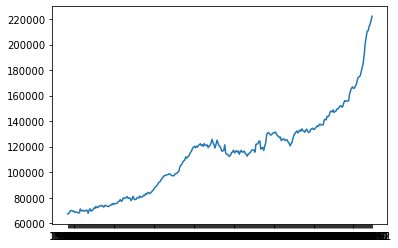

In [30]:
plt.plot(HotSprings["YearMonth"], HotSprings["HomeValue"])
plt.show()

In [31]:
# Time series plot for little rock arkansas metro area
LittleRock = ZHVI[ZHVI["Metro"] == "Little Rock-North Little Rock-Conway"]
LittleRock = LittleRock[["Metro"] + list(LittleRock.columns[9:])]
LittleRock = LittleRock.melt(id_vars = ["Metro"])
LittleRock.columns = ["Metro", "YearMonth", "HomeValue"]
LittleRock = LittleRock.groupby(by = ["Metro", "YearMonth"], as_index = False).mean()
print("All Time Average Home Value = ", int(sum(LittleRock["HomeValue"]) / len(LittleRock["HomeValue"])))

All Time Average Home Value =  137854


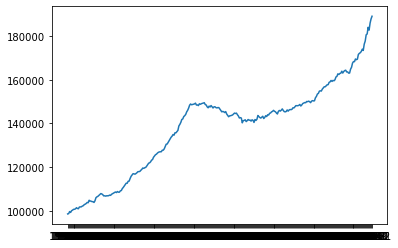

In [32]:
plt.plot(LittleRock["YearMonth"], LittleRock["HomeValue"])
plt.show()

In [33]:
# Time series plot for fayetteville arkansas metro area
Fayetteville = ZHVI[ZHVI["Metro"] == "Fayetteville"]
Fayetteville = Fayetteville[["Metro"] + list(Fayetteville.columns[9:])]
Fayetteville = Fayetteville.melt(id_vars = ["Metro"])
Fayetteville.columns = ["Metro", "YearMonth", "HomeValue"]
Fayetteville = Fayetteville.groupby(by = ["Metro", "YearMonth"], as_index = False).mean()
print("All Time Average Home Value = ", int(sum(Fayetteville["HomeValue"]) / len(Fayetteville["HomeValue"])))

All Time Average Home Value =  124902


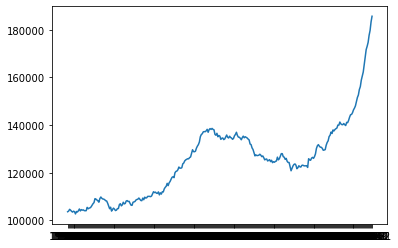

In [34]:
plt.plot(Fayetteville["YearMonth"], Fayetteville["HomeValue"])
plt.show()

In [35]:
# Time series plot for searcy arkansas metro area
Searcy = ZHVI[ZHVI["Metro"] == "Searcy"]
Searcy = Searcy[["Metro"] + list(Searcy.columns[9:])]
Searcy = Searcy.melt(id_vars = ["Metro"])
Searcy.columns = ["Metro", "YearMonth", "HomeValue"]
Searcy = Searcy.groupby(by = ["Metro", "YearMonth"], as_index = False).mean()
print("All Time Average Home Value = ", int(sum(Searcy["HomeValue"]) / len(Searcy["HomeValue"])))

All Time Average Home Value =  79187


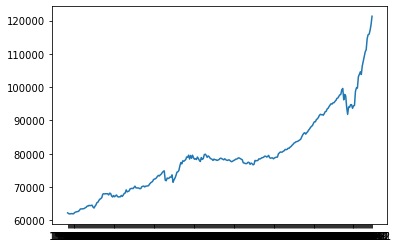

In [36]:
plt.plot(Searcy["YearMonth"], Searcy["HomeValue"])
plt.show()

<p>&nbsp;</p>

## **Model the Data**

<p>&nbsp;</p>

In [37]:
# Create a new dataframe that will be used for the modeling
NewZHVI = ZHVI[["RegionName"] + list(ZHVI.columns[9:])]
NewZHVI = NewZHVI.melt(id_vars = ["RegionName"])
NewZHVI.columns = ["RegionName", "YearMonth", "HomeValue"]

<p>&nbsp;</p>

#### **Example of Forecast**

<p>&nbsp;</p>

In [38]:
# Filter just in one RegionName for testing
Experiment = NewZHVI[NewZHVI["RegionName"] == 10025]
del Experiment["RegionName"]

In [39]:
# Set the YearMonth column as a date index
Experiment.index = pd.to_datetime(Experiment["YearMonth"], format = "%Y%m")
del Experiment["YearMonth"]
Experiment.head(10)

,HomeValue
YearMonth,
1996-01-01,1.853335e+06
1996-02-01,1.853335e+06
1996-03-01,1.853335e+06
1996-04-01,1.853335e+06
1996-05-01,1.853335e+06
1996-06-01,1.853335e+06
1996-07-01,1.853335e+06
1996-08-01,1.853335e+06
1996-09-01,1.853335e+06


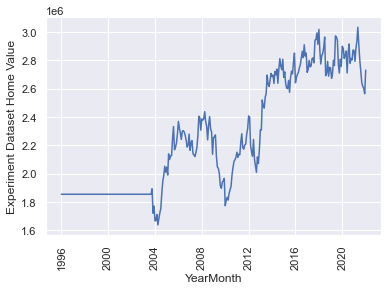

In [40]:
# Plot the time series data
sns.set()
plt.ylabel("Experiment Dataset Home Value")
plt.xlabel("YearMonth")
plt.xticks(rotation = "vertical")
plt.plot(Experiment.index, Experiment["HomeValue"])
plt.show()

In [41]:
# Split into train and test
TrainData = Experiment[Experiment.index < pd.to_datetime("201801", format = "%Y%m")]
TestData = Experiment[Experiment.index >= pd.to_datetime("201801", format = "%Y%m")]

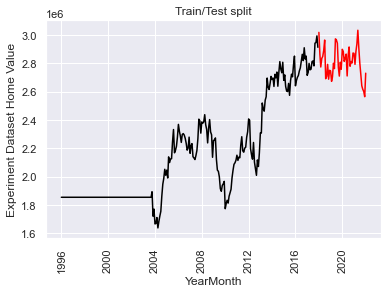

In [42]:
# Plot the train and test split
plt.plot(TrainData, color = "black")
plt.plot(TestData, color = "red")
plt.ylabel("Experiment Dataset Home Value")
plt.xlabel("YearMonth")
plt.xticks(rotation = "vertical")
plt.title("Train/Test split")
plt.show()

In [ ]:
# Calculate holt winters
y_hat_avg = TestData.copy()
fit1 = ExponentialSmoothing(np.asarray(TrainData["HomeValue"]), seasonal_periods = 12, trend = "add", seasonal = "add").fit()
y_hat_avg["HoltWinter"] = fit1.forecast(len(TestData))

In [44]:
# Print out the RMSE
np.sqrt(mean_squared_error(TestData["HomeValue"], y_hat_avg["HoltWinter"]))

159007.8422891078

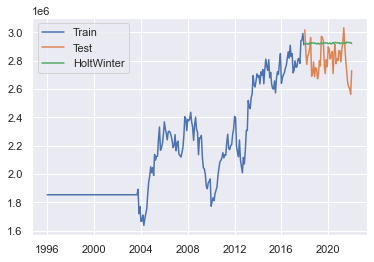

In [45]:
# Show the plot of the forecast and the result
plt.plot(TrainData["HomeValue"], label = "Train")
plt.plot(TestData["HomeValue"], label = "Test")
plt.plot(y_hat_avg["HoltWinter"], label = "HoltWinter")
plt.legend(loc = "best")
plt.show()

<p>&nbsp;</p>

#### **Forecast All Zip Codes**

<p>&nbsp;</p>

In [ ]:
# Create a list of future periods to forecast
FuturePeriods = ["202202", "202203", "202204", "202205", "202206", "202207", "202208",
"202209", "202210", "202211", "202212", "202301", "202302", "202303", "202304", "202305",
"202306", "202307", "202308", "202309", "202310", "202311", "202312"]

# Create a dataframe to store the forecasts in
ForecastData = pd.DataFrame(FuturePeriods, columns = ["YearMonth"])
ForecastData["RegionName"] = ""
ForecastData["Forecast"] = ""

# Iterate through every zip code
for ZipCode in ZHVI["RegionName"].unique():

    # Create a temp dataframe to store the forecasts in
    TempForecastData = pd.DataFrame(FuturePeriods, columns = ["YearMonth"])
    TempForecastData["RegionName"] = ""
    TempForecastData["Forecast"] = ""

    # Set up the forecast dataset for the current zip code
    HistoricalData = NewZHVI[NewZHVI["RegionName"] == ZipCode]
    del HistoricalData["RegionName"]
    HistoricalData.index = pd.to_datetime(HistoricalData["YearMonth"], format = "%Y%m")
    del HistoricalData["YearMonth"]

    # Calculate holt winters
    y_hat_avg = TempForecastData.copy()
    fit1 = ExponentialSmoothing(np.asarray(HistoricalData["HomeValue"]), seasonal_periods = 12, trend = "add", seasonal = "add").fit()
    y_hat_avg["HoltWinter"] = fit1.forecast(len(TempForecastData))

    # Fill in the forecast data dataframe
    TempForecastData["RegionName"] = ZipCode
    TempForecastData["Forecast"] = y_hat_avg["HoltWinter"]

    # Concat that to the main dataframe
    ForecastData = pd.concat([ForecastData, TempForecastData], axis = 0)

In [47]:
# Pivot the forecast columns back out horizontally
ForecastPivoted = pd.pivot_table(ForecastData, values = "Forecast", index = ["RegionName"], columns = "YearMonth", aggfunc = sum)
ForecastPivoted["RegionName"] = ForecastPivoted.index
ForecastPivoted = ForecastPivoted[["RegionName"] + FuturePeriods]
ForecastPivoted = ForecastPivoted.reset_index(drop = True)
ForecastPivoted

YearMonth,RegionName,202202,202203,202204,202205,202206,202207,202208,202209,202210,...,202303,202304,202305,202306,202307,202308,202309,202310,202311,202312
0,501,138296.45751,138779.712264,139788.685599,140406.190025,141436.934251,141715.264053,142674.747063,143510.900865,144173.001459,...,147656.286551,148665.259886,149282.764312,150313.508538,150591.83834,151551.32135,152387.475151,153049.575746,153541.325246,154509.942914
1,601,323867.970651,330049.086194,335060.231039,342390.374356,347795.849142,353806.165731,359446.222371,365756.651024,370699.986266,...,401365.52521,406376.670055,413706.813372,419112.288158,425122.604747,430762.661387,437073.09004,442016.425282,449057.852279,454845.717928
2,602,131919.696989,131922.328477,131924.693446,131927.995551,131930.175824,131933.82531,131935.904533,131938.934901,131939.200244,...,131953.611119,131955.976088,131959.278192,131961.458465,131965.107951,131967.187175,131970.217542,131970.482885,131973.682288,131977.866211
3,605,50224.461681,51190.294581,52140.268929,53090.55565,54057.546179,55183.815027,56320.063829,57981.398386,58145.450872,...,63387.878367,64337.852715,65288.139437,66255.129965,67381.398813,68517.647616,70178.982172,70343.034659,71346.84096,73460.144352
4,606,95487.051344,95487.050883,95487.050421,95487.04996,95487.049499,95487.049037,95487.048576,93621.51507,95370.196831,...,95487.045347,95487.044886,95487.044425,95487.043963,95487.043502,95487.043041,93621.509535,95370.191295,95064.801557,96101.684092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31986,99801,505907.140983,509688.956035,513471.114161,517251.19799,521033.36061,524815.532772,528595.228792,532377.954664,536161.415491,...,555069.497914,558851.65604,562631.739868,566413.902489,570196.074651,573975.77067,577758.496543,581541.95737,585322.612975,589106.169946
31987,99824,462010.961445,464638.317243,467410.334412,470357.229694,472995.652435,475822.025219,478321.595,481414.345611,484418.374822,...,498106.009483,500878.026653,503824.921934,506463.344676,509289.717459,511789.28724,514882.037851,517886.067062,520496.761832,523633.729691
31988,99833,313721.298347,314988.446205,316451.864834,317832.140545,318630.003679,320640.444245,322073.85337,323155.002606,324892.380145,...,331934.902642,333398.321271,334778.596982,335576.460116,337586.900682,339020.309808,340101.459043,341838.836583,343202.867367,344994.631374
31989,99901,406939.211825,410861.420583,414809.508989,418735.732137,422802.946421,426863.41122,430413.760098,434200.40955,438208.693391,...,457864.973518,461813.061924,465739.285072,469806.499356,473866.964155,477417.313033,481203.962485,485212.246326,488992.871322,493321.069366


In [48]:
# Join the forecast pivoted on the original dataframe
JoinedZHVI = ZHVI.merge(ForecastPivoted, how = "inner", on = "RegionName")

<p>&nbsp;</p>

## **Interpret the Data**

<p>&nbsp;</p>

In [ ]:
# What are the top 10 zip codes that grew and declined in value?
Growth = JoinedZHVI[["RegionName", "State", "City", "202201", "202312"]]
Growth["Difference"] = Growth["202312"] - Growth["202201"]
Growth["DifferencePercent"] = Growth["Difference"] / Growth["202201"]
Growth["Difference"] = Growth["Difference"].astype(int)
Growth["202201"] = Growth["202201"].astype(int)
Growth["202312"] = Growth["202312"].astype(int)

In [50]:
# Top 10 growth based on the forecast
Growth.sort_values(by = "DifferencePercent", ascending = False).head(10)

,RegionName,State,City,202201,202312,Difference,DifferencePercent
31839,85535,AZ,Eden,279909,789242,509333,1.81964
30537,58262,ND,Edinburg,67714,187828,120114,1.773843
30824,88424,NM,Grenville,75706,205456,129750,1.713856
16367,79843,TX,Marfa,262080,687306,425226,1.622499
31267,38767,MS,Alligator,87130,228353,141223,1.620837
24709,38639,MS,Jonestown,48530,123411,74881,1.542974
28309,78376,TX,Realitos,105923,255287,149363,1.410101
30697,77463,TX,Sweeny,423280,1017369,594088,1.403536
30548,67857,KS,Kendall,146210,341461,195251,1.335415
2418,662,AL,Isabela,129981,303394,173413,1.334143


<p>&nbsp;</p>

<font size = "5">

**What technique/algorithm/decision process did you use to down sample? (BONUS FOR NOT DOWN SAMPLING)**

I did not use any down sampling in my analysis.

**What 3 zip codes provide the best investment opportunity for the SREIT and why?**

According to the results of my forecast, the best investment opportunities are in the following zip codes.

31839 - Eden AZ
30537 Edinburg ND
30824 Grenville NM

Over the next 2 years, these areas are forecasted to grow as much as 180% of their current value.

<p>&nbsp;</p>

**Resources**  
https://www.kaggle.com/kylet550/single-family-home-values-by-city  
https://sls.gatech.edu/sites/default/files/documents/Toolkit-Docs/hong_fieldguide_zillow.pdf  
https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu  
https://stackabuse.com/matplotlib-line-plot-tutorial-and-examples/  
https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html  
https://builtin.com/data-science/time-series-forecasting-python  
https://tedboy.github.io/pandas/comparison_with_r/comparison_with_r4.html